# Jet Background subtraction via NN, Multiplicty and Area based methods

In [1]:
import ROOT
import os.path 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd 
import datetime

import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/02


2022-06-03 10:25:35.144149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/libfabric/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/lib/release:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/ippcp/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/ipp/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/itac/latest/slib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mkl/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib/x64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib/emu:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/compiler/lib/intel64_lin:/sw/is

# Config file defining ML varibles, training sets and data 

In [41]:
################################# CONFIG #########################################

All_ROOT_VARIBLES = ['weight', 'scaledweight', 'median_pt_over_area','median_npart_over_area',
'fastjet_rho', 'event_average_pt', 'AreaBased', 'NumberBased','event_median_pt',
'jetpt','jeteta','jetphi','jetpt_pythia','jetpt_pythia_fraction','jetarea',
'average_track_pt','median_track_pt','jetnparts', 'track0pt','track1pt',
'track2pt','track3pt','track4pt','jetangularity','trackptvariance','trackptskewness','trackptkurtosis']

SPECTATOR_VARIBLES = ['scaledweight','AreaBased', 'NumberBased']

INPUT_VARIBLES = ['event_median_pt', 'jetpt','jetarea', 'average_track_pt','jetnparts',
'track0pt','track1pt','track2pt','track3pt','track4pt',
'jetangularity','trackptvariance']

TARGET = ['jetpt_pythia']

#TTV_SPLITS = ['split title', 'train lambda', 'test lambda', 'validation lambda']
TTV_SPLITS = ['unifrom_split','(int)rdfentry_%5!=0 ','((int)rdfentry_%5==0 && (int)rdfentry_%2 ==0)','((int)rdfentry_%5==0 && (int)rdfentry_%2 ==1)']
JET_PARAMS = [0.2,0.4]
CENT_BINS = [0,1] # 0-10,20-40
RAWPTCUT = 10.0
PYTHIACUT = 0.0

def gen_precuts(jetparm, rawptcut, pythia_percentage):
    etacut = 1.1 - jetparm
    CUTS =[f'TMath::Abs(jeteta) <= {etacut:.1f}',
            f'jetpt > {rawptcut}',
            f'jetpt_pythia > {pythia_percentage}']
    return CUTS

In [42]:
# Run all 
run_all_for_config(JET_PARAMS,CENT_BINS,RAWPTCUT,PYTHIACUT,TTV_SPLITS)

SPLIT REPORT
PARAMETERS:
  R=0.2 0-10%
Input files:

    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin0.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin1.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin2.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin3.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin4.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin5.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin6.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin7.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin8.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin9.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin10.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin11.root
    pre-processed-dat

2022-06-03 11:15:38.856546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/libfabric/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/lib/release:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mpi/latest/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/ippcp/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/ipp/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/itac/latest/slib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/mkl/latest/lib/intel64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib/x64:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/lib/emu:/sw/isaac/compilers/intel/oneAPI_2021.2.0/compiler/latest/linux/compiler/lib/intel64_lin:/sw/isaac/compil

# Function definitions

In [45]:
def get_filelist(jetparm, centrality):
    """
    Make filelist based of jet parameter (0-10, 20-40) and centralitiy (0,1)
    """
    filelist = []
    # set the cent/rsting 
    if jetparm == 0.2:
        rstring = 'R02'
    if jetparm == 0.4:
        rstring = 'R04'
    if centrality == 0:
        centstring = '0to10'
    if centrality == 1:
        centstring = '20to40'     
    
    filestring_header = f'pre-processed-data/jet-trees-formatted/AuAu_200GeV_{rstring}_{centstring}_ptbin'
    for ptbin in range(0,19):
        filelist.append(f'{filestring_header}{ptbin}.root')
    
    return filelist
    
def dataset_name(jetparm, centrality):
    """
    Make dataset title based of jet parameter (0-10, 20-40) and centralitiy (0,1)
    """

    if jetparm == 0.2:
        rstring = 'R02'
    if jetparm == 0.4:
        rstring = 'R04'
    if centrality == 0:
        centstring = '0to10'
    if centrality == 1:
        centstring = '20to40'    

    return f'{rstring}_{centstring}'

def train_test_split_to_TFILE(jetparm, centrality,precuts,ttvcuts):
    """
    Load ROOT files, create root df, preform cuts, write to train-test-split/
    """
    filelist = get_filelist(jetparm,centrality)
    dataset = dataset_name(jetparm,centrality)

    if centrality == 0:
        cent_string = '0-10%'
    if centrality == 1:
        cent_string = '20-40%'
    
    
    #enable mult-threading
    ROOT.EnableImplicitMT()
    # define varibles in rootfile
    columns = ROOT.std.vector["string"](All_ROOT_VARIBLES)
    chain = ROOT.TChain('outTree')

    for filename in filelist:
        chain.Add(filename)

    # fstrings for split data paths
    TreeName = 'jetTree'
    trainfile = f'train-test-split/{ttvcuts[0]:s}_training_{dataset:s}.root'
    testfile = f'train-test-split/{ttvcuts[0]:s}_testing_{dataset:s}.root'
    valfile = f'train-test-split/{ttvcuts[0]:s}_validation_{dataset:s}.root'

    # split root files with rdataframe filters  
    formjets = ROOT.RDataFrame(chain) 

    # precut filters
    for cut in precuts:
        formjets = formjets.Filter(cut,f'   {cut}')

    # split data
    train = formjets.Filter(f'{ttvcuts[1]}', f"{dataset:s} SELECTED TRAINING JETS")
    train.Snapshot(TreeName, trainfile, columns)
    train_rep = train.Report()
    test= formjets.Filter(f'{ttvcuts[2]}',f"{dataset:s} SELECTED TESTING JETS")
    test.Snapshot(TreeName, testfile, columns)
    test_rep = test.Report()
    validate = formjets.Filter(f'{ttvcuts[3]}',f"{dataset:s} SELECTED VALIDATION JETS")
    validate.Snapshot(TreeName, valfile, columns)
    validate_rep = validate.Report()

    print(f'SPLIT REPORT\nPARAMETERS:\n  R={jetparm:.1f} {cent_string:s}\nInput files:\n')
    for filename in filelist: 
        print(f'    {filename}')
    print('\nOutput files:\n')
    print(f'    training: {trainfile:s}\n   validation: {valfile:s}\n   testing: {testfile:s}\n')
    print('Cut Reports:\n')
    train_rep.Print()
    test_rep.Print()
    validate_rep.Print()

def split_all_datasets(jet_parms, cent_bins, rawpt, pythiapt, ttvcuts):
        for R in jet_parms:
            precuts = gen_precuts(R,rawpt,pythiapt)
            for cent in cent_bins:
                train_test_split_to_TFILE(R,cent,precuts,ttvcuts)

def dnn_model(InputVaribles):
    """
    Keras model architecture for neural network from similiar to Rudy paper 
    """
    # get length of input varibles from config
    inputdim = len(InputVaribles)
    return keras.Sequential(
    [
        layers.Dense(100,input_shape=(inputdim,),activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='relu')
    ])

def load_ttv_data(splitset, type, dataset):
    """
    Read data from ROOT files: x (input varibles), y (target), z (spectators)
    """
    tfile = f'train-test-split/{splitset:s}_{type:s}_{dataset:s}.root'
    TreeName = 'jetTree'
    data= ROOT.RDataFrame(TreeName, tfile).AsNumpy()
    x = np.vstack([data[var] for var in INPUT_VARIBLES]).T
    y = np.vstack([data[var] for var in TARGET]).T
    z = np.vstack([data[var] for var in SPECTATOR_VARIBLES]).T
    return x, y, z  
    
def train_models(splitset, dataset):
    """
    Trains the neural network and ckpts using tensorboard
    """
    checkpoint_path = f'checkpoints/{splitset:s}_{dataset:s}.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

    log_dir = f'checkpoints/tb/{splitset:s}_{dataset:s}_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    x_train, y_train, z_train = load_ttv_data(splitset,'training',dataset)
    x_val, y_val, z_val = load_ttv_data(splitset,'validation',dataset)


    # Set up model 
    model = dnn_model(INPUT_VARIBLES)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    
    batch_size = 128
    epochnum = 20
    model.fit(x=x_train,y=y_train,epochs=epochnum,batch_size=batch_size, validation_data=(x_val,y_val),callbacks=[tensorboard_callback,cp_callback])

def train_all_data_sets(JET_PARAMS,CENT_BINS):
    for R in JET_PARAMS:
        for cent in CENT_BINS:
            print(f'R = {R:.1f} cent = {cent}')
            ds = dataset_name(R,cent)
            train_models(TTV_SPLITS[0],ds)

def evaluate_models(splitset, dataset):
    """
    Produces final result root file
    """
    # testing data
    rootfilename = f'results/results_{splitset:s}_{dataset:s}.root'
    TreeName = 'resultsTree'

    x_test, y_test, z_test = load_ttv_data(splitset, 'testing', dataset)

    checkpoint_path = f'checkpoints/{splitset:s}_{dataset:s}.ckpt'

    model = dnn_model(INPUT_VARIBLES)
    model.compile(loss='mse', optimizer='adam')
    model.load_weights(checkpoint_path)

   # get NN prediction

    NeuralNetworkBased = model(x_test)

    # Linear Models
    weights = z_test[:,0]
    AreaBased = z_test[:,1]
    MultiplicityBased = z_test[:,2]
    # truth value
    pythiapt = y_test[:,0]
    # other values for result file
    rawjetpt = x_test[:,1]
    

    # varibles to fill TTree 
    NNpred = np.empty((1), dtype="float32")
    ABpred = np.empty((1), dtype="float32")
    MBpred = np.empty((1), dtype="float32")
    truthPt = np.empty((1), dtype="float32")
    rawPt = np.empty((1), dtype="float32")
    Scaledweights = np.empty((1), dtype="float32")

    # TTree architechure
    root_file = ROOT.TFile(rootfilename, "RECREATE")
    tree = ROOT.TTree(TreeName, TreeName)
    tree.Branch("NeuralNetworkBased", NNpred, "NeuralNetworkBased/F")
    tree.Branch("AreaBased", ABpred, "AreaBased/F")
    tree.Branch("MultiplicityBased", MBpred, "MultiplicityBased/F")
    tree.Branch("pythiapt", truthPt, "pythiapt/F")
    tree.Branch("rawjetpt", rawPt, "rawjetpt/F")
    tree.Branch("weights", Scaledweights, "weights/F")

    # fill TTree
    for i in range(pythiapt.shape[0]):
        NNpred[0] = NeuralNetworkBased[i]
        ABpred[0] = AreaBased[i]
        MBpred[0] = MultiplicityBased[i]
        truthPt[0] = pythiapt[i]
        rawPt[0] = rawjetpt[i]
        Scaledweights[0] = weights[i] 
        tree.Fill()
        
    root_file.Write()  

def write_all_results(JET_PARAMS, CENT_BINS, TTV_SPLITS):
    for R in JET_PARAMS:
        for cent in CENT_BINS:
            print(f'writing results for R = {R:.1f} cent = {cent}')
            ds = dataset_name(R,cent)
            evaluate_models(TTV_SPLITS[0], ds)

def run_all_for_config(JET_PARAMS,CENT_BINS,RAWPTCUT,PYTHIACUT,TTV_SPLITS):
    split_all_datasets(JET_PARAMS,CENT_BINS,RAWPTCUT,PYTHIACUT,TTV_SPLITS)
    train_all_data_sets(JET_PARAMS,CENT_BINS)
    write_all_results(JET_PARAMS, CENT_BINS, TTV_SPLITS)



In [7]:
def concat_for_dendrogram(jetparm, centrality, precuts):
    """
    Load ROOT files, create root df, preform cuts, write to train-test-split/
    """
    filelist = get_filelist(jetparm,centrality)
    dataset = dataset_name(jetparm,centrality)

    if centrality == 0:
        cent_string = '0-10%'
    if centrality == 1:
        cent_string = '20-40%'
    
    
    #enable mult-threading
    ROOT.EnableImplicitMT()
    # define varibles in rootfile
    columns = ROOT.std.vector["string"](All_ROOT_VARIBLES)
    chain = ROOT.TChain('outTree')

    for filename in filelist:
        chain.Add(filename)

    # fstrings for split data paths
    TreeName = 'jetTree'
    rootfile = f'train-test-split/ALL_{dataset:s}.root'

    # split root files with rdataframe filters  
    formjets = ROOT.RDataFrame(chain) 

    # precut filters
    for cut in precuts:
        formjets = formjets.Filter(cut,f'   {cut}')

    # split data
    formjets.Snapshot(TreeName, rootfile, columns)

def load_all_data(dataset):
    """
    Read data from ROOT files: x (input varibles), y (target), z (spectators)
    """
    tfile = f'train-test-split/ALL_{dataset:s}.root'
    TreeName = 'jetTree'
    data= ROOT.RDataFrame(TreeName, tfile).AsNumpy()
    x = np.vstack([data[var] for var in INPUT_VARIBLES]).T
    y = np.vstack([data[var] for var in TARGET]).T
    z = np.vstack([data[var] for var in SPECTATOR_VARIBLES]).T
    return x, y, z  
    

In [32]:
def load_dataset_to_pandas(jetparm, centrality, vars):
    """
    Read data from ROOT files and retrun pd.dataframe
    """

    # get dataset filelist
    filelist = get_filelist(jetparm,centrality)
    dataset = dataset_name(jetparm,centrality)

    if centrality == 0:
        cent_string = '0-10%'
    if centrality == 1:
        cent_string = '20-40%'

    #enable mult-threading
    ROOT.EnableImplicitMT()
    # define varibles in rootfile
    columns = ROOT.std.vector["string"](vars)
    chain = ROOT.TChain('outTree')

    for filename in filelist:
        chain.Add(filename)
    
    print('Input files:')
    for filename in filelist: 
        print(f'    {filename}')

    # create rdataframe
    rdf = ROOT.RDataFrame(chain) 
    # convert to np array
    np_df = rdf.AsNumpy(columns = vars)
    # return pandas dataframe
    pdf = pd.DataFrame(np_df)
    print(f'Number of jets: {pdf.shape[0]}, Number of varibles: {pdf.shape[1]} ')
    print('Columns:')
    print(f'{pdf.columns}')
    print('Header:')
    print(f'{pdf.head()}')

    return pdf

def pdf_to_tfile(pdf,vars,outfilename):
    """
    Write pandas dataframe to ttree and save
    """
    data = {key: pdf[key].values for key in vars}
    # root data frame
    rdf = ROOT.RDF.MakeNumpyDataFrame(data)
    # save
    rdf.Snapshot('tree',outfilename,vars)

In [33]:
pdf_r2_0to10 = load_dataset_to_pandas(0.2,0,All_ROOT_VARIBLES)

Input files:
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin0.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin1.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin2.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin3.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin4.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin5.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin6.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin7.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin8.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin9.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin10.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0to10_ptbin11.root
    pre-processed-data/jet-trees-formatted/AuAu_200GeV_R02_0t

In [34]:
pdf_to_tfile(pdf_r2_0to10,INPUT_VARIBLES,'testout.root')

Index(['weight', 'scaledweight', 'median_pt_over_area',
       'median_npart_over_area', 'fastjet_rho', 'event_average_pt',
       'AreaBased', 'NumberBased', 'event_median_pt', 'jetpt', 'jeteta',
       'jetphi', 'jetpt_pythia', 'jetpt_pythia_fraction', 'jetarea',
       'average_track_pt', 'median_track_pt', 'jetnparts', 'track0pt',
       'track1pt', 'track2pt', 'track3pt', 'track4pt', 'jetangularity',
       'trackptvariance', 'trackptskewness', 'trackptkurtosis'],
      dtype='object')

In [ ]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestRegressor

In [ ]:
R =0.2
cent = 0


splitset = TTV_SPLITS[0]
dataset = dataset_name(R,cent)

In [15]:
score_zeros = []
zerod_varible = []
delta_score = []

x_test, y_test, z_test = load_ttv_data(splitset, 'testing', dataset)
checkpoint_path = f'checkpoints/{splitset:s}_{dataset:s}.ckpt'

model = dnn_model(INPUT_VARIBLES)
model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
model.load_weights(checkpoint_path)
run_scores = np.zeros([0,1])
starting_score =  model.evaluate(x_test, y_test, verbose=0)[1]
x_temp
for i in range(x_test.shape[1]):
    x_temp[:,:] = x_test[:,:]
    x_temp[:,i] = 0
    zerod_varible.append(INPUT_VARIBLES[i])   
    tmp_score =model.evaluate(x_temp, y_test, verbose=0)[1]
    score_zeros.append(tmp_score)
    delta_score.append(tmp_score-starting_score)
    print(f'zerovar = {INPUT_VARIBLES[i]:s}, score = {tmp_score}\n exmp: {x_temp[0,:]}')

    
perm_scoring = ['neg_mean_squared_error']
r = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=0, scoring=perm_scoring)

zerovar = event_median_pt, score = 1.4513444900512695
 exmp: [ 0.         12.16801834  0.11967972  0.52904427 23.          1.71688819
  0.90861535  0.85909182  0.83048874  0.64910096  0.12543744  0.10908259]
zerovar = jetpt, score = 5.592787265777588
 exmp: [ 0.40702555  0.          0.11967972  0.52904427 23.          1.71688819
  0.90861535  0.85909182  0.83048874  0.64910096  0.12543744  0.10908259]
zerovar = jetarea, score = 1.4671317338943481
 exmp: [ 0.40702555 12.16801834  0.          0.52904427 23.          1.71688819
  0.90861535  0.85909182  0.83048874  0.64910096  0.12543744  0.10908259]
zerovar = average_track_pt, score = 2.3110756874084473
 exmp: [ 0.40702555 12.16801834  0.11967972  0.         23.          1.71688819
  0.90861535  0.85909182  0.83048874  0.64910096  0.12543744  0.10908259]
zerovar = jetnparts, score = 50.55152130126953
 exmp: [ 0.40702555 12.16801834  0.11967972  0.52904427  0.          1.71688819
  0.90861535  0.85909182  0.83048874  0.64910096  0.1254374

2022-06-03 02:46:25.036230: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open checkpoints/unifrom_split_R02_0to10.ckpt: FAILED_PRECONDITION: checkpoints/unifrom_split_R02_0to10.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [68]:
feature_importance=[]
  
for i in range(len(delta_score)):
      feature_importance.append([delta_score[i],0, INPUT_VARIBLES[i]])
feature_importance.sort(reverse=False)
sort_index = []
  
for x in feat_imp:
    sort_index.append(x[1])

r_temp = r['neg_mean_squared_error']
permutation_importance = []
for i in r_temp.importances_mean.argsort()[::-1]:
    permutation_importance.append([r_temp.importances_mean[i],r_temp.importances_std[i],INPUT_VARIBLES[i]])
    print(f'    {INPUT_VARIBLES[i]:<15}'
                f'    {r_temp.importances_mean[i]:.3f}'
                f' +/- {r_temp.importances_std[i]:.3f}')

    jetpt              40.816 +/- 0.276
    track0pt           24.275 +/- 0.118
    track1pt           7.025 +/- 0.032
    trackptvariance    1.966 +/- 0.017
    track2pt           1.782 +/- 0.023
    jetnparts          0.585 +/- 0.009
    track3pt           0.417 +/- 0.007
    track4pt           0.247 +/- 0.004
    average_track_pt    0.208 +/- 0.006
    jetarea            0.009 +/- 0.001
    jetangularity      0.000 +/- 0.000
    event_median_pt    -0.000 +/- 0.000


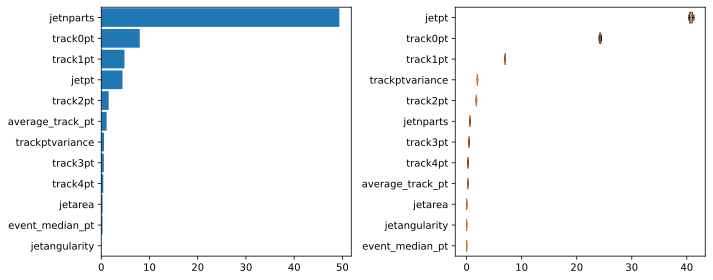

In [74]:
tree_indices = np.arange(0, len(feature_importance)) + 0.5
perm_sorted_idx = r_temp.importances_mean.argsort()
fimp_arr = np.zeros(0)
ticklabels = []
boxlabels = []
for i in range(len(feature_importance)):
    ticklabels.append(feature_importance[i][2])
    fimp_arr = np.append(fimp_arr,[feature_importance[i][0]])
    
for i in range(len(feature_importance)):
    boxlabels.append(INPUT_VARIBLES[perm_sorted_idx[i]])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.barh(tree_indices, fimp_arr  , height=0.9)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(ticklabels)
ax1.set_ylim((0, len(feature_importance)))
ax2.boxplot(
    r_temp.importances[perm_sorted_idx].T,
    vert=False,
    labels=boxlabels,
)
fig.tight_layout()
plt.show()

NameError: name 'x_train' is not defined

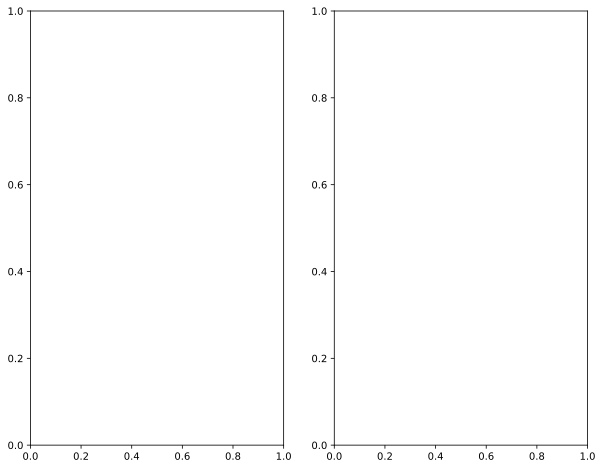

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

corr = spearmanr(x_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=INPUT_VARIBLES, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()

In [11]:
clf = RandomForestRegressor(max_depth=2, random_state=42)
clf.fit(x_train, y_train[:,0])

NameError: name 'x_train' is not defined

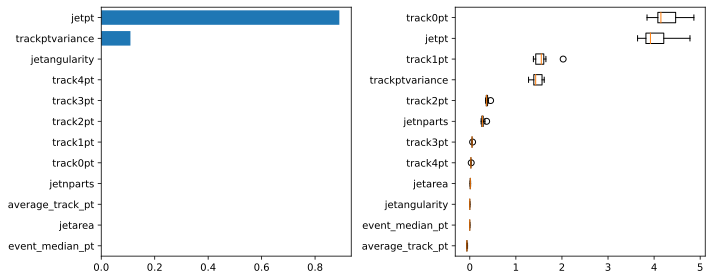

In [33]:
r_temp = r['neg_mean_absolute_percentage_error']
perm_sorted_idx = r_temp.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

ticklabels = []
for i in range(len(tree_importance_sorted_idx)):
    ticklabels.append(INPUT_VARIBLES[tree_importance_sorted_idx[i]])
boxlabels = []
for i in range(len(tree_importance_sorted_idx)):
    boxlabels.append(INPUT_VARIBLES[perm_sorted_idx[i]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(ticklabels)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    r_temp.importances[perm_sorted_idx].T,
    vert=False,
    labels=boxlabels,
)
fig.tight_layout()
plt.show()

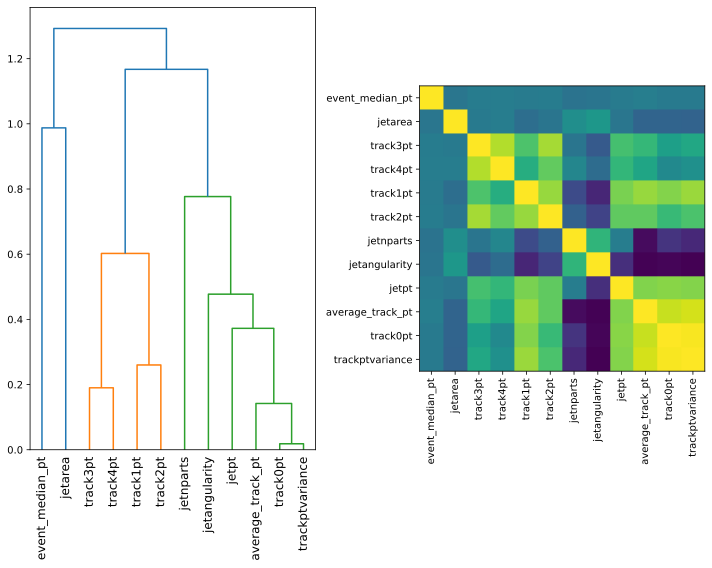

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

corr = spearmanr(x_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=INPUT_VARIBLES, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()

In [ ]:
%tensorboard --logdir 